pip install pandas

In [2]:
import numpy as np
import pandas as pd
import sys
import pathlib

pip install -U scikit-learn==1.0.2

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve
from sklearn.feature_selection import RFECV

!pip install lightgbm

!pip install catboost

!pip install xgboost

In [4]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

!pip install seaborn

In [5]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [8]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1_macro',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [13]:
def choise_features(train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['target'])
    y_train = train['target']
    X_test = test.drop(columns=['target'])
    y_test = test['target']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': cat_feats,
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [14]:
def choise_features_model(train, test, model):
    X_train = train.drop(columns=['target'])
    y_train = train['target']
    X_test = test.drop(columns=['target'])
    y_test = test['target']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
cwd = pathlib.Path().cwd()
sys.path.append(cwd.as_posix())
data_folder = cwd.joinpath('data')
model_folder = cwd.joinpath('models')

In [16]:
train = pd.read_csv(data_folder.joinpath('train.csv'))
test = pd.read_csv(data_folder.joinpath('test.csv'))

train.drop(columns=['time_max'], inplace=True)
test.drop(columns=['time_max'], inplace=True)

In [18]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 54.57 MB
Memory usage after optimization is: 15.83 MB
Decreased by 71.0%
Memory usage of dataframe is 23.39 MB
Memory usage after optimization is: 6.78 MB
Decreased by 71.0%


In [19]:
train.target.value_counts(normalize=True)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286106 entries, 0 to 286105
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   target             286106 non-null  float32
 1   id                 286106 non-null  int32  
 2   buy_time_train     286106 non-null  int32  
 3   vas_id             286106 non-null  int8   
 4   time_delta         286106 non-null  float32
 5   component_1        286106 non-null  float32
 6   component_3        286106 non-null  float32
 7   month              286106 non-null  int8   
 8   day                286106 non-null  int16  
 9   weekofyear         286106 non-null  int8   
 10  how_old            286106 non-null  int32  
 11  novelty            286106 non-null  float32
 12  vas_id_1           286106 non-null  int8   
 13  vas_id_2           286106 non-null  int8   
 14  vas_id_4           286106 non-null  int8   
 15  vas_id_5           286106 non-null  int8   
 16  va

In [18]:
train.describe()

,target,id,buy_time_train,vas_id,time_delta,component_1,component_3,month,day,weekofyear,...,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9,vas_id_ord,vas_id_date_dif_1,vas_id_date_dif_2,vas_id_mean,log_vas_id_mean
count,286106.000000,2.861060e+05,2.861060e+05,286106.000000,286106.0,2.861060e+05,2.861060e+05,286106.000000,286106.000000,286106.000000,...,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000,286106.000000
mean,0.090750,2.092392e+06,1.541682e+09,2.953968,5456794.5,2.841800e+00,-3.327438e-03,10.682198,311.669430,44.524204,...,0.006309,0.015519,0.000930,0.000692,0.001741,0.013243,0.149819,0.688511,0.090750,-3.269179
std,0.287253,1.252824e+06,4.237310e+06,2.007375,4243547.5,4.133786e+08,3.919400e+06,1.569909,49.042937,7.006134,...,0.090777,0.135656,0.031381,0.030253,0.043005,0.147976,3.101163,6.663344,0.142978,1.142655
min,0.000000,2.000000e+00,1.531084e+09,1.000000,0.0,-1.268137e+08,-1.142244e+08,7.000000,189.000000,27.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015690,-4.092966
25%,0.000000,1.015328e+06,1.538341e+09,1.000000,1814400.0,-1.267104e+08,-5.003790e+03,9.000000,273.000000,39.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020008,-3.862847
50%,0.000000,2.041707e+06,1.543180e+09,2.000000,4838400.0,-1.267104e+08,-5.003789e+03,11.000000,329.000000,47.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023038,-3.728128
75%,0.000000,3.061003e+06,1.544994e+09,5.000000,9072000.0,-1.267104e+08,-5.003789e+03,12.000000,350.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023038,-3.728128
max,1.000000,4.362694e+06,1.546204e+09,9.000000,15120000.0,1.419893e+09,1.522282e+09,12.000000,364.000000,52.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,162.000000,168.000000,0.437451,-0.824507


In [20]:
TARGET_NAME = 'target'

In [21]:
df_balanced=balance_df_by_target_advance(train, TARGET_NAME, method='over')
df_balanced[TARGET_NAME].value_counts()

/tmp/ipykernel_31310/1821944573.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0.0    260142
1.0    259640
Name: target, dtype: int64

In [23]:
train['vas_id'].value_counts()

2    91213
1    86510
5    41032
6    29457
4    26265
7     5800
8     3811
9     2018
Name: vas_id, dtype: int64

In [24]:
df_balanced['vas_id'].value_counts()

6    145729
2    107584
1    104489
4     97065
5     47098
7      6591
9      6065
8      5161
Name: vas_id, dtype: int64

В целом стратификация по vas_id не сильно нарушена.

In [25]:
train['vas_id'].loc[train['target']==1].value_counts()

6    12886
4     7882
1     1993
2     1825
5      681
9      452
8      154
7       91
Name: vas_id, dtype: int64

In [26]:
df_balanced['vas_id'].loc[df_balanced['target']==1].value_counts()

6    129158
4     78682
1     19972
2     18196
5      6747
9      4499
8      1504
7       882
Name: vas_id, dtype: int64

единиц стало больше на порядок.

In [22]:
# для Катбуста
def to_int(df, cat_feats):
    df[cat_feats] = df[cat_feats].astype('int32')
    return df

In [23]:
train = to_int(train, ['vas_id'])
test = to_int(test, ['vas_id'])
df_balanced = to_int(df_balanced, ['vas_id'])

# Выбор модели

In [24]:
disbalance = train['target'].value_counts()[0] / train['target'].value_counts()[1]
disbalance

10.019334463102759

In [25]:
disbalance_bal = df_balanced['target'].value_counts()[0] / df_balanced['target'].value_counts()[1]
disbalance_bal

1.0019334463102758

# XGBClassifier

scale_pos_weight не помог

In [31]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(train['target'][train['target'] == 0]))/float(len(train['target'][train['target'] == 1]))
w_array = np.array([1]*train['target'].shape[0])
w_array[train['target']==1] = weight_ratio
w_array[train['target']==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [46]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [47]:
choise_features_model(train, test, model_xgb)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    260142
         1.0       0.80      0.38      0.52     25964

    accuracy                           0.94    286106
   macro avg       0.87      0.69      0.74    286106
weighted avg       0.93      0.94      0.92    286106

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    111491
         1.0       0.72      0.28      0.41     11127

    accuracy                           0.93    122618
   macro avg       0.83      0.64      0.68    122618
weighted avg       0.91      0.93      0.91    122618

CONFUSION MATRIX

col_0        0     1
target              
0.0     110291  1200
1.0       7993  3134


,feature_name,importance
0,id,0.003286
1,buy_time_train,0.066808
2,vas_id,0.011718
3,time_delta,0.002412
4,component_1,0.002726
5,component_3,0.002734
6,month,0.000000
7,day,0.000000
8,weekofyear,0.000000
9,how_old,0.000000


In [48]:
#run_cv(model_xgb, kfold_cv, X_train, y_train, model_name="model_xgb");

In [49]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [50]:
choise_features_model(df_balanced, test, model_xgb)

0.0    0.500483
1.0    0.499517
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91    260142
         1.0       0.87      0.96      0.92    259640

    accuracy                           0.91    519782
   macro avg       0.92      0.91      0.91    519782
weighted avg       0.92      0.91      0.91    519782

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.94      0.56     11127

    accuracy                           0.87    122618
   macro avg       0.70      0.90      0.74    122618
weighted avg       0.94      0.87      0.89    122618

CONFUSION MATRIX

col_0       0      1
target              
0.0     95855  15636
1.0       694  10433


,feature_name,importance
0,id,0.004485
1,buy_time_train,0.089720
2,vas_id,0.013902
3,time_delta,0.002626
4,component_1,0.003071
5,component_3,0.003913
6,month,0.000000
7,day,0.000000
8,weekofyear,0.000000
9,how_old,0.000000


In [51]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

# LGBMClassifier

In [52]:
model_lgbm = LGBMClassifier(random_state=21)
choise_features_model(train, test, model_lgbm)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    260142
         1.0       0.79      0.33      0.47     25964

    accuracy                           0.93    286106
   macro avg       0.86      0.66      0.71    286106
weighted avg       0.92      0.93      0.92    286106

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    111491
         1.0       0.77      0.26      0.39     11127

    accuracy                           0.93    122618
   macro avg       0.85      0.63      0.67    122618
weighted avg       0.92      0.93      0.91    122618

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     110624   867
1.0       8230  2897


,feature_name,importance
0,id,582
1,buy_time_train,597
2,vas_id,153
3,time_delta,239
4,component_1,152
5,component_3,282
6,month,0
7,day,0
8,weekofyear,0
9,how_old,53


In [53]:
model_lgbm = LGBMClassifier(random_state=21)
choise_features_model(df_balanced, test, model_lgbm)

0.0    0.500483
1.0    0.499517
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90    260142
         1.0       0.87      0.96      0.91    259640

    accuracy                           0.91    519782
   macro avg       0.91      0.91      0.91    519782
weighted avg       0.91      0.91      0.91    519782

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.70      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95511  15980
1.0       596  10531


,feature_name,importance
0,id,565
1,buy_time_train,652
2,vas_id,203
3,time_delta,272
4,component_1,163
5,component_3,293
6,month,3
7,day,0
8,weekofyear,0
9,how_old,29


In [54]:
run_cv(model_lgbm, kfold_cv, df_balanced.drop(columns=['target']), df_balanced['target'], model_name="model_lgbm");

model_lgbm: f1_macro = 0.91 (+/- 0.00)


# CatBoostClassifier

In [55]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': ['vas_id'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [56]:
model_catb = catb.CatBoostClassifier(**frozen_params)
choise_features_model(train, test, model_catb)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    260142
         1.0       0.41      0.96      0.58     25964

    accuracy                           0.87    286106
   macro avg       0.70      0.91      0.75    286106
weighted avg       0.94      0.87      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    111491
         1.0       0.42      0.91      0.57     11127

    accuracy                           0.88    122618
   macro avg       0.70      0.89      0.75    122618
weighted avg       0.94      0.88      0.90    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     97296  14195
1.0       985  10142


,feature_name,importance
0,id,5.069729
1,buy_time_train,15.706955
2,vas_id,5.980055
3,time_delta,4.426993
4,component_1,1.510807
5,component_3,3.495237
6,month,0.334665
7,day,12.292523
8,weekofyear,7.234256
9,how_old,3.356606


In [57]:
run_cv(model_catb, kfold_cv, df_balanced.drop(columns=['target']), df_balanced['target'], model_name="model_catb");

model_catb: f1_macro = 0.89 (+/- 0.00)


In [58]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5)

!pip install ipywidgets

In [61]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)
grid = {'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
grid_search = model.randomized_search(grid, train.drop(columns=['target']), train['target'], 
                                      n_iter=50, cv=cv, 
                                      stratified=True,
                                      plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9136468938
bestIteration = 294

0:	loss: 0.9136469	best: 0.9136469 (0)	total: 47.9s	remaining: 7m 10s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9141980666
bestIteration = 213

1:	loss: 0.9141981	best: 0.9141981 (1)	total: 1m 28s	remaining: 5m 55s

bestTest = 0.9139767793
bestIteration = 286

2:	loss: 0.9139768	best: 0.9141981 (1)	total: 2m 15s	remaining: 5m 15s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9142511396
bestIteration = 113

3:	loss: 0.9142511	best: 0.9142511 (3)	total: 2m 42s	remaining: 4m 3s

bestTest = 0.9136883124
bestIteration = 293

4:	loss: 0.9136883	best: 0.9142511 (3)	total: 3m 31s	remaining: 3m 31s

bestTest = 0.9146456536
bestIteration = 244

5:	loss: 0.9146457	best: 0.9146457 (5)	total: 4m 19s	remaining: 2m 53s

bestTest = 0.9137463048
bestIteration = 284

6:	loss: 0.9137463	best: 0.9146457 (5)	total: 5m 9s	remaining: 2m 12s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.91414253

In [62]:
cv_results = pd.DataFrame(grid_search["cv_results"])
cv_results

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.903814,0.000434,0.903814,0.000217,0.577061,0.017978,0.577001,0.017621
1,1,0.903806,0.000422,0.903837,0.000183,0.505464,0.012042,0.505315,0.011783
2,2,0.903949,0.000200,0.903941,0.000405,0.453794,0.010168,0.453668,0.009798
3,3,0.903809,0.000426,0.903830,0.000192,0.415301,0.009246,0.415156,0.008688
4,4,0.904082,0.000634,0.904223,0.000344,0.384333,0.008510,0.384248,0.008003
...,...,...,...,...,...,...,...,...,...
274,274,0.911272,0.000431,0.912277,0.000462,0.260355,0.000861,0.254692,0.001949
275,275,0.911294,0.000423,0.912279,0.000476,0.260331,0.000872,0.254655,0.001969
276,276,0.911287,0.000426,0.912267,0.000461,0.260332,0.000868,0.254634,0.001988
277,277,0.911294,0.000423,0.912279,0.000476,0.260335,0.000863,0.254613,0.002003


In [63]:
grid_search["params"]

{'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [68]:
best_model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5,
                                l2_leaf_reg=9, 
                                learning_rate=0.1
                                )
choise_features_model(train, test, best_model)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    260142
         1.0       0.40      0.96      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.70      0.91      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95409  16082
1.0       589  10538


,feature_name,importance
0,id,1.151958
1,buy_time_train,8.009623
2,vas_id,7.125164
3,time_delta,0.323743
4,component_1,0.323002
5,component_3,0.367257
6,month,0.217135
7,day,15.184036
8,weekofyear,9.417172
9,how_old,6.997710


In [69]:
y_pred = best_model.predict_proba(test.drop(columns=['target']))

for i in np.linspace(0.8, 0.9, num=10):
    print(f"threshold : {i}")
    print(classification_report(test['target'], (y_pred[:, 1] > i) * 1))
    print('***************************')

threshold : 0.8
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    111491
         1.0       0.49      0.77      0.60     11127

    accuracy                           0.91    122618
   macro avg       0.73      0.85      0.77    122618
weighted avg       0.93      0.91      0.92    122618

***************************
threshold : 0.8111111111111111
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95    111491
         1.0       0.50      0.76      0.60     11127

    accuracy                           0.91    122618
   macro avg       0.74      0.84      0.77    122618
weighted avg       0.93      0.91      0.92    122618

***************************
threshold : 0.8222222222222223
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    111491
         1.0       0.50      0.74      0.60     11127

    accuracy                           0.91    1

# Теперь попробую LGBMClassifier на сбалансированных данных.


In [26]:
model_lgbm = LGBMClassifier(random_state=21)

# Выбор метода балансировки датасета

!pip install imblearn

conda update conda -y && conda update python -y

In [27]:
df_balanced_tomek = balance_df_by_target_advance(train, 'target', method='tomek')

X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
y_train_tomek = df_balanced_tomek[TARGET_NAME]

model_lgbm_t = LGBMClassifier(random_state=21)
choise_features_model(df_balanced_tomek, test, model_lgbm_t)

0.0    0.904999
1.0    0.095001
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    247337
         1.0       0.78      0.39      0.52     25964

    accuracy                           0.93    273301
   macro avg       0.86      0.69      0.74    273301
weighted avg       0.92      0.93      0.92    273301

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96    111491
         1.0       0.68      0.34      0.46     11127

    accuracy                           0.93    122618
   macro avg       0.81      0.66      0.71    122618
weighted avg       0.91      0.93      0.91    122618

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     109694  1797
1.0       7303  3824


,feature_name,importance
0,id,599
1,buy_time_train,613
2,vas_id,155
3,time_delta,248
4,component_1,144
5,component_3,262
6,month,1
7,day,0
8,weekofyear,0
9,how_old,56


In [28]:
df_smote = balance_df_by_target_advance(train, 'target', method='smote')

model_lgbm_s = LGBMClassifier(random_state=21)
choise_features_model(df_smote, test, model_lgbm_s)
df_smote.shape

0.0    0.5
1.0    0.5
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93    260142
         1.0       0.90      0.97      0.94    260142

    accuracy                           0.93    520284
   macro avg       0.94      0.93      0.93    520284
weighted avg       0.94      0.93      0.93    520284

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    111491
         1.0       0.41      0.91      0.56     11127

    accuracy                           0.87    122618
   macro avg       0.70      0.89      0.74    122618
weighted avg       0.94      0.87      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     96676  14815
1.0      1001  10126


(520284, 25)

In [29]:
df_under = balance_df_by_target_advance(train, 'target', method='under')

model_lgbm_u = LGBMClassifier(random_state=21)
choise_features_model(df_under, test, model_lgbm_u)
df_under.shape

/tmp/ipykernel_31310/1821944573.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp.iloc[


0.0    0.5
1.0    0.5
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     25964
         1.0       0.87      0.96      0.91     25964

    accuracy                           0.91     51928
   macro avg       0.91      0.91      0.91     51928
weighted avg       0.91      0.91      0.91     51928

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95228  16263
1.0       582  10545


(51928, 25)

In [30]:
run_cv(model_lgbm_u, kfold_cv, df_under.drop(columns=['target']), df_under['target'],
       model_name="model_lgbm_u");

model_lgbm_u: f1_macro = 0.90 (+/- 0.01)


In [31]:
train = df_under

# Удаление признаков

In [32]:
estimator = LGBMClassifier(random_state=21)

min_features_to_select = 10
selector = RFECV(estimator, step=1, cv=5,  scoring='f1_macro', 
                 min_features_to_select=min_features_to_select)
selector = selector.fit(train.drop(columns=['target']), train['target'])
selector.support_

array([ True,  True,  True,  True,  True,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True, False, False,
       False,  True, False,  True,  True, False])

Optimal number of features : 15


/home/jb/anaconda3/envs/MEGA_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


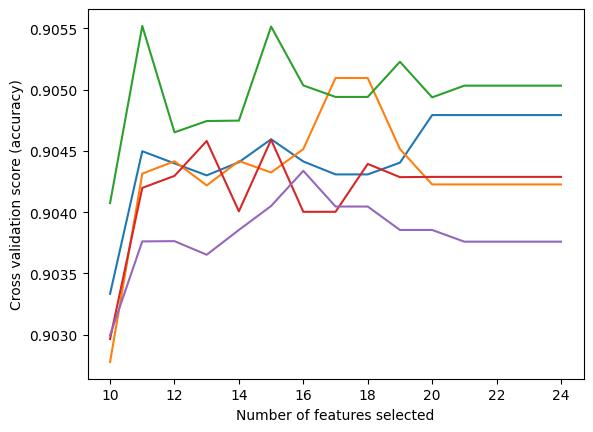

In [33]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(selector.grid_scores_) + min_features_to_select),
    selector.grid_scores_,
)
plt.show()

In [34]:
selector.support_

array([ True,  True,  True,  True,  True,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True, False, False,
       False,  True, False,  True,  True, False])

In [35]:
value = np.array(train.drop(columns=['target']).columns.to_list())
mask = np.array(selector.support_)
last_col = list(value[mask])
last_col.extend(['target'])
last_col

['id',
 'buy_time_train',
 'vas_id',
 'time_delta',
 'component_1',
 'component_3',
 'how_old',
 'vas_id_1',
 'vas_id_2',
 'vas_id_4',
 'vas_id_5',
 'vas_id_6',
 'vas_id_ord',
 'vas_id_date_dif_2',
 'vas_id_mean',
 'target']

In [36]:
last_col = ['id',
 'buy_time_train',
 'vas_id',
 'time_delta',
 'component_1',
 'component_3',
 'how_old',
 'vas_id_1',
 'vas_id_2',
 'vas_id_4',
 'vas_id_5',
 'vas_id_6',
 'vas_id_7',
 'vas_id_8',
 'vas_id_ord',
 'vas_id_date_dif_1',
 'vas_id_date_dif_2',
 'vas_id_mean',
 'log_vas_id_mean',
 'target']

# Укорачиваю признаки

In [38]:
train_short = train[last_col]
test_short = test[last_col]

In [39]:
estimator = LGBMClassifier(random_state=21)
feature_importances = choise_features_model(train_short, test_short, estimator)

0.0    0.5
1.0    0.5
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     25964
         1.0       0.87      0.96      0.91     25964

    accuracy                           0.91     51928
   macro avg       0.91      0.91      0.91     51928
weighted avg       0.91      0.91      0.91     51928

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.39      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95340  16151
1.0       587  10540


Скор лучше не стал, но для ускорения приму этот результат.

In [40]:
train, test = train_short, test_short

In [43]:
feature_importances

,feature_name,importance
0,id,599
1,buy_time_train,526
2,vas_id,179
3,time_delta,308
4,component_1,228
5,component_3,356
6,how_old,62
7,vas_id_1,71
8,vas_id_2,106
9,vas_id_4,44


То что id самый важный - косяк. Но думаю при оптимизации модели это исправится.

In [44]:
train_data_file = data_folder.joinpath("train_boost.csv")
test_data_file = data_folder.joinpath("test_boost.csv")

train.to_csv(train_data_file, index=False, header=False)
test.to_csv(test_data_file, index=False, header=False)

# Подбор гиперпараметров

!pip install hyperopt

In [47]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
import lightgbm as lgbm

In [48]:
X = train.drop(['target'], axis=1)
Y = train['target']

In [49]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

def gini_lgb(truth, predictions):
    score = gini(truth, predictions) / gini(truth, truth)
    return 'gini', score, True

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [50]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, X, Y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 44, 'colsample_bytree': '0.659'}
 10%|█         | 1/10 [00:16<02:26, 16.32s/trial, best loss: 0.8954536478297455]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 88, 'colsample_bytree': '0.526'}               
 20%|██        | 2/10 [00:37<02:34, 19.25s/trial, best loss: 0.8952100140950972]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 82, 'colsample_bytree': '0.776'}               
 30%|███       | 3/10 [01:00<02:26, 20.98s/trial, best loss: 0.8947775594528572]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 50, 'colsample_bytree': '0.554'}               
 40%|████      | 4/10 [01:17<01:55, 19.25s/trial, best loss: 0.8947775594528572]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.896 params {'num_leaves': 40, 'colsample_bytree': '0.578'}               
 50%|█████     | 5/10 [01:29<01:24, 16.82s/trial, best loss: 0.8947775594528572]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 36, 'colsample_bytree': '0.639'}               
 60%|██████    | 6/10 [01:41<01:00, 15.21s/trial, best loss: 0.8947775594528572]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 84, 'colsample_bytree': '0.496'}               
 70%|███████   | 7/10 [02:04<00:52, 17.58s/trial, best loss: 0.8947775594528572]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.894 params {'num_leaves': 118, 'colsample_bytree': '0.311'}              
 80%|████████  | 8/10 [02:32<00:42, 21.05s/trial, best loss: 0.8936256519767964]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.895 params {'num_leaves': 62, 'colsample_bytree': '0.428'}               
 90%|█████████ | 9/10 [02:48<00:19, 19.28s/trial, best loss: 0.8936256519767964]

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)

/tmp/i

Gini 0.894 params {'num_leaves': 10, 'colsample_bytree': '0.891'}               
100%|██████████| 10/10 [02:56<00:00, 17.64s/trial, best loss: 0.8935034988687068]


/tmp/ipykernel_31310/3082248066.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)



In [51]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.8913036223449964, 'num_leaves': 10.0}


In [53]:
lgbm_model = lgbm.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=10,
    colsample_bytree=0.8913036223449964
)

In [54]:
feature_importances = choise_features_model(train, test, lgbm_model)

0.0    0.5
1.0    0.5
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     25964
         1.0       0.86      0.96      0.91     25964

    accuracy                           0.90     51928
   macro avg       0.91      0.90      0.90     51928
weighted avg       0.91      0.90      0.90     51928

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.95      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.88    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95052  16439
1.0       567  10560


In [55]:
y_pred = lgbm_model.predict_proba(test.drop(columns=['target']))

for i in np.linspace(0.1, 0.9, num=25):
    print(f"threshold : {i}")
    print(classification_report(test['target'], (y_pred[:, 1] > i) * 1))
    print('***************************')

threshold : 0.1
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88    111491
         1.0       0.31      0.96      0.47     11127

    accuracy                           0.80    122618
   macro avg       0.65      0.87      0.67    122618
weighted avg       0.93      0.80      0.84    122618

***************************
threshold : 0.13333333333333333
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90    111491
         1.0       0.36      0.96      0.52     11127

    accuracy                           0.84    122618
   macro avg       0.68      0.89      0.71    122618
weighted avg       0.94      0.84      0.87    122618

***************************
threshold : 0.16666666666666669
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91    111491
         1.0       0.38      0.95      0.54     11127

    accuracy                           0.86   

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    111491
         1.0       0.51      0.72      0.60     11127

    accuracy                           0.91    122618
   macro avg       0.74      0.83      0.77    122618
weighted avg       0.93      0.91      0.92    122618

***************************
threshold : 0.8666666666666666
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    111491
         1.0       0.57      0.53      0.55     11127

    accuracy                           0.92    122618
   macro avg       0.76      0.75      0.76    122618
weighted avg       0.92      0.92      0.92    122618

***************************
threshold : 0.9
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    111491
         1.0       0.77      0.24      0.37     11127

    accuracy                           0.92    122618
   macro avg       0.85  

переобучение

# ЛУЧШАЯ НЕЙРОННАЯ СЕТЬ

на сбалансированном трейне

!pip install -U tensorflow-addons==0.18.0

!pip install tensorflow==2.9.2

In [59]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras import callbacks
from keras import models
from sklearn.metrics import classification_report

2022-11-27 16:39:34.786150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 16:39:34.786180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [60]:
tfa.__version__

'0.18.0'

In [75]:
train_data = pd.read_csv(data_folder.joinpath('train.csv'))
test_data = pd.read_csv(data_folder.joinpath('test.csv'))

train_data.drop(columns=['time_max'], inplace=True)
test_data.drop(columns=['time_max'], inplace=True)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (286106, 25)
Test dataset shape: (122618, 25)


In [76]:
train_data = balance_df_by_target_advance(train_data, 'target', method='over')

/tmp/ipykernel_31310/1821944573.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


In [80]:
train_data.columns

Index(['target', 'id', 'buy_time_train', 'vas_id', 'time_delta', 'component_1',
       'component_3', 'month', 'day', 'weekofyear', 'how_old', 'novelty',
       'vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7',
       'vas_id_8', 'vas_id_9', 'vas_id_ord', 'vas_id_date_dif_1',
       'vas_id_date_dif_2', 'vas_id_mean', 'log_vas_id_mean'],
      dtype='object')

In [81]:
train_data_columns = ['target', 'id', 'buy_time_train', 'vas_id', 'time_delta', 'component_1',
       'component_3', 'month', 'day', 'weekofyear', 'how_old', 'novelty',
       'vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7',
       'vas_id_8', 'vas_id_9', 'vas_id_ord', 'vas_id_date_dif_1',
       'vas_id_date_dif_2', 'vas_id_mean', 'log_vas_id_mean']

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = pd.DataFrame(scaler.transform(train_data), columns=train_data_columns)
train_data.head()

,target,id,buy_time_train,vas_id,time_delta,component_1,component_3,month,day,weekofyear,...,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9,vas_id_ord,vas_id_date_dif_1,vas_id_date_dif_2,vas_id_mean,log_vas_id_mean
0,0.0,0.864351,0.96,0.000,0.00,0.000067,0.069795,1.0,0.96,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017423,0.111624
1,1.0,0.990180,0.92,0.625,0.76,0.946115,0.069798,1.0,0.92,0.92,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2,1.0,0.217731,0.68,0.375,0.12,0.000067,0.069795,0.8,0.68,0.68,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.674328,0.885016
3,1.0,0.052879,0.92,0.625,0.00,0.000067,0.069795,1.0,0.92,0.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
4,1.0,0.395337,0.96,0.375,0.84,0.000067,0.069795,1.0,0.96,0.96,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.674328,0.885016


In [83]:
test_data = pd.DataFrame(scaler.transform(test_data), columns=train_data_columns)
test_data.head(2)

,target,id,buy_time_train,vas_id,time_delta,component_1,component_3,month,day,weekofyear,...,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9,vas_id_ord,vas_id_date_dif_1,vas_id_date_dif_2,vas_id_mean,log_vas_id_mean
0,1.0,0.164683,0.28,0.125,0.16,0.000067,0.069795,0.2,0.28,0.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010239,0.070406
1,0.0,0.536963,0.92,0.375,0.44,0.000067,0.069795,1.0,0.92,0.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.674328,0.885016


In [84]:
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 99.14 MB
Memory usage after optimization is: 49.57 MB
Decreased by 50.0%
Memory usage of dataframe is 23.39 MB
Memory usage after optimization is: 11.69 MB
Decreased by 50.0%


In [85]:
test_data = test_data.astype('float32')
test_data.target = test_data.target.map(
    {1.0:'accept', 0.0: 'reject'}
)
test_data.head(2)

,target,id,buy_time_train,vas_id,time_delta,component_1,component_3,month,day,weekofyear,...,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9,vas_id_ord,vas_id_date_dif_1,vas_id_date_dif_2,vas_id_mean,log_vas_id_mean
0,accept,0.164683,0.28,0.125,0.16,0.000067,0.069795,0.2,0.28,0.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010239,0.070406
1,reject,0.536963,0.92,0.375,0.44,0.000067,0.069795,1.0,0.92,0.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.674328,0.885016


In [86]:
train_data = train_data.astype('float32')
train_data.target = train_data.target.map(
    {1:'accept', 0: 'reject'}
)
train_data.columns.tolist()

['target',
 'id',
 'buy_time_train',
 'vas_id',
 'time_delta',
 'component_1',
 'component_3',
 'month',
 'day',
 'weekofyear',
 'how_old',
 'novelty',
 'vas_id_1',
 'vas_id_2',
 'vas_id_4',
 'vas_id_5',
 'vas_id_6',
 'vas_id_7',
 'vas_id_8',
 'vas_id_9',
 'vas_id_ord',
 'vas_id_date_dif_1',
 'vas_id_date_dif_2',
 'vas_id_mean',
 'log_vas_id_mean']

In [103]:
CSV_HEADER = ['target', 'id', 'buy_time_train', 'vas_id', 'time_delta', 'component_1', 'component_3',
 'month', 'day', 'weekofyear', 'how_old', 'novelty', 'vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5',
 'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9', 'vas_id_ord', 'vas_id_date_dif_1', 'vas_id_date_dif_2',
 'vas_id_mean', 'log_vas_id_mean']

In [104]:
CATEGORICAL_FEATURE_NAMES = ["vas_id"]

In [105]:
train_data[CATEGORICAL_FEATURE_NAMES] = train_data[CATEGORICAL_FEATURE_NAMES].astype('str')
test_data[CATEGORICAL_FEATURE_NAMES] = test_data[CATEGORICAL_FEATURE_NAMES].astype('str')

In [106]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    'id', 'time_delta', 'component_1', 'component_3', 'month', 'day', 
    'weekofyear', 'how_old', 'novelty', 'vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5',
    'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9', 'vas_id_ord', 'vas_id_date_dif_1', 
    'vas_id_date_dif_2', 'vas_id_mean', 'log_vas_id_mean'
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "vas_id": sorted(list(train_data["vas_id"].unique()))
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "buy_time_train"
# A list of the categorical feature names.
#CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "target"
# A list of the labels of the target features.
TARGET_LABELS = ["reject", "accept"]

In [107]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [108]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [111]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

In [112]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)



    model_checkpoint = callbacks.ModelCheckpoint(filepath='model_best_{epoch}',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto') #,
                                   #save_freq=20)

    

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                        factor=0.1,
                                        patience=0,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.001,
                                        cooldown=0,
                                        min_lr=1e-10)
    
    early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.001,
                                     patience=15,
                                     verbose=1,
                                     mode='auto',
                                     baseline=None,
                                     restore_best_weights=False)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset,
        callbacks=[model_checkpoint, early_stop]
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [113]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [114]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [115]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [116]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [117]:
baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Total model weights: 9325
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [121]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=30,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/30
   1962/Unknown - 35s 17ms/step - loss: 0.1912 - accuracy: 0.9040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_loss improved from inf to 0.20290, saving model to model_best_1
INFO:tensorflow:Assets written to: model_best_1/assets
1962/1962 [==============================] - 44s 21ms/step - loss: 0.1912 - accuracy: 0.9040 - val_loss: 0.2029 - val_accuracy: 0.8642
Epoch 2/30
1959/1962 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `


Epoch 15: val_loss did not improve from 0.20290
1962/1962 [==============================] - 17s 9ms/step - loss: 0.1913 - accuracy: 0.9040 - val_loss: 0.2250 - val_accuracy: 0.8632
Epoch 16/30
1957/1962 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 16: val_loss did not improve from 0.20290
1962/1962 [==============================] - 18s 9ms/step - loss: 0.1913 - accuracy: 0.9040 - val_loss: 0.2421 - val_accuracy: 0.8599
Epoch 16: early stopping
Model training finished
Validation accuracy: 85.99%


In [122]:
y_test = test_data['target']
y_test = y_test.map(
    {'accept': 1, 'reject': 0}
)
y_pred = baseline_model.predict(get_dataset_from_csv(test_data_file))
y_pred = y_pred.reshape((-1,))

958/958 [==============================] - 6s 6ms/step


In [123]:
for i in np.linspace(0.1, 0.9, num=30):
    print(f"threshold : {i}")
    print(classification_report(y_test, (y_pred > i) * 1))
    print('***************************')

threshold : 0.1
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    111491
           1       0.29      0.97      0.45     11127

    accuracy                           0.78    122618
   macro avg       0.64      0.86      0.66    122618
weighted avg       0.93      0.78      0.83    122618

***************************
threshold : 0.12758620689655173
              precision    recall  f1-score   support

           0       0.99      0.81      0.90    111491
           1       0.34      0.96      0.50     11127

    accuracy                           0.83    122618
   macro avg       0.67      0.89      0.70    122618
weighted avg       0.94      0.83      0.86    122618

***************************
threshold : 0.15517241379310345
              precision    recall  f1-score   support

           0       0.99      0.83      0.91    111491
           1       0.37      0.95      0.53     11127

    accuracy                           0.85   

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    111491
           1       0.40      0.94      0.56     11127

    accuracy                           0.87    122618
   macro avg       0.70      0.90      0.74    122618
weighted avg       0.94      0.87      0.89    122618

***************************
threshold : 0.7344827586206897
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    111491
           1       0.41      0.92      0.57     11127

    accuracy                           0.87    122618
   macro avg       0.70      0.90      0.75    122618
weighted avg       0.94      0.87      0.89    122618

***************************
threshold : 0.7620689655172415
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    111491
           1       0.42      0.91      0.58     11127

    accuracy                           0.88    122618
   macro a

In [125]:
best_model=models.load_model("model_best_1")

In [126]:
y_pred = best_model.predict(get_dataset_from_csv(test_data_file))
y_pred = y_pred.reshape((-1,))

958/958 [==============================] - 6s 6ms/step


In [127]:
for i in np.linspace(0.1, 0.9, num=30):
    print(f"threshold : {i}")
    print(classification_report(y_test, (y_pred > i) * 1))
    print('***************************')

threshold : 0.1
              precision    recall  f1-score   support

           0       0.99      0.82      0.90    111491
           1       0.35      0.96      0.51     11127

    accuracy                           0.83    122618
   macro avg       0.67      0.89      0.70    122618
weighted avg       0.94      0.83      0.86    122618

***************************
threshold : 0.12758620689655173
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    111491
           1       0.37      0.95      0.53     11127

    accuracy                           0.85    122618
   macro avg       0.68      0.89      0.72    122618
weighted avg       0.94      0.85      0.87    122618

***************************
threshold : 0.15517241379310345
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    111491
           1       0.37      0.95      0.53     11127

    accuracy                           0.85   

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    111491
           1       0.42      0.91      0.58     11127

    accuracy                           0.88    122618
   macro avg       0.71      0.89      0.75    122618
weighted avg       0.94      0.88      0.90    122618

***************************
threshold : 0.7344827586206897
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    111491
           1       0.43      0.89      0.58     11127

    accuracy                           0.88    122618
   macro avg       0.71      0.89      0.76    122618
weighted avg       0.94      0.88      0.90    122618

***************************
threshold : 0.7620689655172415
              precision    recall  f1-score   support

           0       0.98      0.90      0.94    111491
           1       0.45      0.86      0.59     11127

    accuracy                           0.89    122618
   macro a

Бог любит троицу. 3 лучшие модели показали одни и те же метрики. Скорее всего, если это даже и локальный, но очень значимый для этого датасета минимум. Но LGB переобучен, у нейронной сети тоже есть небольшое переобучение, а Катбуст дает одинаковые метрики на трейне и тесте. Кроме того, он проще и легче чем нейронка. Но шеф сказал использовать нейронку.

In [128]:
!pip freeze > requirements.txt 